## Prepare environment

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, Subset

In [2]:
import torchvision.transforms as T
from torchvision import datasets
from torchvision import models

In [3]:
import random
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from sklearn.model_selection import train_test_split

In [4]:
random.seed(42)
np.random.seed(42)
torch.manual_seed(42)

In [5]:
transforms = T.Compose([
    T.ToTensor(),
    T.Normalize((0.1307,), (0.3081,)),
])

dataset = datasets.MNIST('./', download=True, transform=transforms)
test_dataset = datasets.MNIST('./', train=False, transform=transforms)

In [6]:
BATCH_SIZE = 64

In [7]:
targets = dataset.targets
train_idx, val_idx = train_test_split(np.arange(len(targets)), test_size=0.2, random_state=42, stratify=targets)

train_dataset = Subset(dataset, train_idx)
val_dataset = Subset(dataset, val_idx)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=BATCH_SIZE)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE)

In [8]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [9]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, 3, 1)
        self.conv2 = nn.Conv2d(32, 64, 3, 1)
        # self.dropout1 = nn.Dropout(0.25)
        # self.dropout2 = nn.Dropout(0.5)
        self.fc1 = nn.Linear(9216, 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(x)
        x = self.conv2(x)
        x = F.relu(x)
        x = F.max_pool2d(x, 2)
        # x = self.dropout1(x)
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = F.relu(x)
        # x = self.dropout2(x)
        x = self.fc2(x)
        return x

## Mini-batch gradient descent

Mini-batch gradient descent is the golden ratio between BGD and SGD, because it inherits the best features from both algorithms. It performs an update for an every subset of training examples of a fixed size $m$:

$\theta^{(i+1)} = \theta^{(i)} - \lambda \nabla_{\theta} J(\theta_{1}^{(i)}, ..., \theta_{n}^{(i)}, x_{1}^{(j, j + m)}, ..., x_{n}^{(j, j + m)}, y^{(j, j + m)})$

In this approach, the variance of the parameter updates is significantly reduced, which make converge of the algorithm more stable

Although, this algorithm is a combination of the best features of BGD and SGD, it's not flawless. Mini-batch GD requires precised tuning of the learning rate (if it's too small - converge speed will significantly decrease, if it's too large - the loss function will fluctuate around minimum and, as a result, it will hinder convergence) and the algorithm not effective with noisy and highly non-convex functions, so the chance of being trapped in local minimum is bigger, than in other algorithms.

As was shown in the original paper, there are other major challenges, that may occur:
 - The learning rate requires scheduling in order to make the algorithm reach the optimal point. The scheduler adjust it during training (by reducing the learning rate according to a pre-defined value or when the change in objective between epochs falls below a threshold);
 - The algorithm is not effective on sparse data (when features have different frequencies), because the same learning rate applies to all parameter updates;
 - The more saddle point function $J(\theta_{1}^{(i)}, ..., \theta_{n}^{(i)})$ have, the less effective algorithm becomes;

In [10]:
model = Net()
model = model.to(device)

In [11]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=1e-3)

In [12]:
EPOCHS = 100
PATIENCE = 5

best_loss = np.inf
patience = 0
epoch = 0

### MGD Training

In [13]:
mgd_history = list()
mgd_acc = 0

for epoch in tqdm(range(epoch, EPOCHS)):
  model.train()

  running_loss = list()

  tqdm_loader = tqdm(train_loader)

  for x, y in tqdm_loader:
    x = x.to(device)
    y = y.to(device)

    y_hat = model(x)

    optimizer.zero_grad()
    loss = criterion(y_hat, y)
    loss.backward()
    optimizer.step()

    running_loss.append(loss.item())

    tqdm_loader.set_description(
              f'Loss: {np.mean(running_loss):.4f}'
            )

  valid_loss = list()
  model.eval()

  with torch.no_grad():
    correct = 0
    for x, y in val_loader:
      x = x.to(device)
      y = y.to(device)

      y_hat = model(x)

      loss = criterion(y_hat, y)

      valid_loss.append(loss.item())

      correct += (torch.argmax(y_hat, 1) == y).float().sum()

  accuracy = 100 * correct / len(val_dataset)

  mgd_history.append(np.mean(running_loss))

  valid_loss = np.mean(valid_loss)
  if valid_loss < best_loss:
    best_loss = valid_loss
    patience = 0
    # torch.save(model.state_dict(), 'best.pt')
    mgd_acc = accuracy

  print(
      f'Epoch: {epoch+1}/{EPOCHS} - Val_loss: {valid_loss:.4f}. Accuracy: {accuracy:.2f}'
      )

  patience += 1
  if patience >= PATIENCE:
    print('Out of patience')
    break

# torch.save(model.state_dict(), 'last.pt')

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/750 [00:00<?, ?it/s]

Epoch: 1/100 - Val_loss: 0.8138. Accuracy: 81.83


  0%|          | 0/750 [00:00<?, ?it/s]

Epoch: 2/100 - Val_loss: 0.3949. Accuracy: 88.60


  0%|          | 0/750 [00:00<?, ?it/s]

Epoch: 3/100 - Val_loss: 0.3355. Accuracy: 90.36


  0%|          | 0/750 [00:00<?, ?it/s]

Epoch: 4/100 - Val_loss: 0.3013. Accuracy: 91.37


  0%|          | 0/750 [00:00<?, ?it/s]

Epoch: 5/100 - Val_loss: 0.2814. Accuracy: 91.78


  0%|          | 0/750 [00:00<?, ?it/s]

Epoch: 6/100 - Val_loss: 0.2605. Accuracy: 92.47


  0%|          | 0/750 [00:00<?, ?it/s]

Epoch: 7/100 - Val_loss: 0.2443. Accuracy: 92.92


  0%|          | 0/750 [00:00<?, ?it/s]

Epoch: 8/100 - Val_loss: 0.2322. Accuracy: 93.35


  0%|          | 0/750 [00:00<?, ?it/s]

Epoch: 9/100 - Val_loss: 0.2153. Accuracy: 93.75


  0%|          | 0/750 [00:00<?, ?it/s]

Epoch: 10/100 - Val_loss: 0.2053. Accuracy: 94.10


  0%|          | 0/750 [00:00<?, ?it/s]

Epoch: 11/100 - Val_loss: 0.1949. Accuracy: 94.46


  0%|          | 0/750 [00:00<?, ?it/s]

Epoch: 12/100 - Val_loss: 0.1857. Accuracy: 94.67


  0%|          | 0/750 [00:00<?, ?it/s]

Epoch: 13/100 - Val_loss: 0.1769. Accuracy: 94.97


  0%|          | 0/750 [00:00<?, ?it/s]

Epoch: 14/100 - Val_loss: 0.1679. Accuracy: 95.22


  0%|          | 0/750 [00:00<?, ?it/s]

Epoch: 15/100 - Val_loss: 0.1619. Accuracy: 95.50


  0%|          | 0/750 [00:00<?, ?it/s]

Epoch: 16/100 - Val_loss: 0.1557. Accuracy: 95.54


  0%|          | 0/750 [00:00<?, ?it/s]

Epoch: 17/100 - Val_loss: 0.1522. Accuracy: 95.67


  0%|          | 0/750 [00:00<?, ?it/s]

Epoch: 18/100 - Val_loss: 0.1444. Accuracy: 95.88


  0%|          | 0/750 [00:00<?, ?it/s]

Epoch: 19/100 - Val_loss: 0.1407. Accuracy: 96.04


  0%|          | 0/750 [00:00<?, ?it/s]

Epoch: 20/100 - Val_loss: 0.1355. Accuracy: 96.14


  0%|          | 0/750 [00:00<?, ?it/s]

Epoch: 21/100 - Val_loss: 0.1367. Accuracy: 95.97


  0%|          | 0/750 [00:00<?, ?it/s]

Epoch: 22/100 - Val_loss: 0.1275. Accuracy: 96.42


  0%|          | 0/750 [00:00<?, ?it/s]

Epoch: 23/100 - Val_loss: 0.1301. Accuracy: 96.30


  0%|          | 0/750 [00:00<?, ?it/s]

Epoch: 24/100 - Val_loss: 0.1194. Accuracy: 96.57


  0%|          | 0/750 [00:00<?, ?it/s]

Epoch: 25/100 - Val_loss: 0.1202. Accuracy: 96.57


  0%|          | 0/750 [00:00<?, ?it/s]

Epoch: 26/100 - Val_loss: 0.1181. Accuracy: 96.53


  0%|          | 0/750 [00:00<?, ?it/s]

Epoch: 27/100 - Val_loss: 0.1132. Accuracy: 96.86


  0%|          | 0/750 [00:00<?, ?it/s]

Epoch: 28/100 - Val_loss: 0.1103. Accuracy: 96.88


  0%|          | 0/750 [00:00<?, ?it/s]

Epoch: 29/100 - Val_loss: 0.1120. Accuracy: 96.86


  0%|          | 0/750 [00:00<?, ?it/s]

Epoch: 30/100 - Val_loss: 0.1082. Accuracy: 96.98


  0%|          | 0/750 [00:00<?, ?it/s]

Epoch: 31/100 - Val_loss: 0.1061. Accuracy: 97.04


  0%|          | 0/750 [00:00<?, ?it/s]

Epoch: 32/100 - Val_loss: 0.1048. Accuracy: 96.97


  0%|          | 0/750 [00:00<?, ?it/s]

Epoch: 33/100 - Val_loss: 0.1012. Accuracy: 97.17


  0%|          | 0/750 [00:00<?, ?it/s]

Epoch: 34/100 - Val_loss: 0.0999. Accuracy: 97.18


  0%|          | 0/750 [00:00<?, ?it/s]

Epoch: 35/100 - Val_loss: 0.0985. Accuracy: 97.14


  0%|          | 0/750 [00:00<?, ?it/s]

Epoch: 36/100 - Val_loss: 0.0957. Accuracy: 97.20


  0%|          | 0/750 [00:00<?, ?it/s]

Epoch: 37/100 - Val_loss: 0.0953. Accuracy: 97.27


  0%|          | 0/750 [00:00<?, ?it/s]

Epoch: 38/100 - Val_loss: 0.1030. Accuracy: 96.97


  0%|          | 0/750 [00:00<?, ?it/s]

Epoch: 39/100 - Val_loss: 0.0919. Accuracy: 97.36


  0%|          | 0/750 [00:00<?, ?it/s]

Epoch: 40/100 - Val_loss: 0.0943. Accuracy: 97.21


  0%|          | 0/750 [00:00<?, ?it/s]

Epoch: 41/100 - Val_loss: 0.0895. Accuracy: 97.41


  0%|          | 0/750 [00:00<?, ?it/s]

Epoch: 42/100 - Val_loss: 0.0902. Accuracy: 97.46


  0%|          | 0/750 [00:00<?, ?it/s]

Epoch: 43/100 - Val_loss: 0.0887. Accuracy: 97.27


  0%|          | 0/750 [00:00<?, ?it/s]

Epoch: 44/100 - Val_loss: 0.0881. Accuracy: 97.35


  0%|          | 0/750 [00:00<?, ?it/s]

Epoch: 45/100 - Val_loss: 0.0862. Accuracy: 97.46


  0%|          | 0/750 [00:00<?, ?it/s]

Epoch: 46/100 - Val_loss: 0.0839. Accuracy: 97.56


  0%|          | 0/750 [00:00<?, ?it/s]

Epoch: 47/100 - Val_loss: 0.0829. Accuracy: 97.62


  0%|          | 0/750 [00:00<?, ?it/s]

Epoch: 48/100 - Val_loss: 0.0842. Accuracy: 97.53


  0%|          | 0/750 [00:00<?, ?it/s]

Epoch: 49/100 - Val_loss: 0.0842. Accuracy: 97.53


  0%|          | 0/750 [00:00<?, ?it/s]

Epoch: 50/100 - Val_loss: 0.0844. Accuracy: 97.51


  0%|          | 0/750 [00:00<?, ?it/s]

Epoch: 51/100 - Val_loss: 0.0845. Accuracy: 97.57
Out of patience


## Gradient methods with adaptive learning rate

In the previous modification of **SGD**, the learning rate $ \lambda $ was fixed in size, so the problem with tuning it is still relevant to avoid either slow convergence or complete diverge. The following method modifications tend to solve this major issue.

## AdaGrad

The AdaGrad algorithm adapts the learning rate to the parameters, performing larger updates for infrequent and smaller updates for frequent parameters: given learning rate $ \lambda $ value is divided on some term $ G_{i} $ that accumulates gradient values from previous iterations:

$ \theta^{(i+1)} = \theta^{(i)} - \frac{\lambda}{\sqrt{G_{i} + \epsilon}} \odot g_{i} $, where $ g_{i} = \nabla_{\theta} J(\theta^{(i)})$, $ \epsilon $ is a smoothing term (a small coefficient, usually equals $ 3 \cdot 10^{-6} $, that prevents the denominator from turning to zero) and  $ G_{i} $ is a combination of the previously accumulated gradient terms and element-wise product of $ g_{i} $ on itself: $ G_{i} = G_{i-1} + g_{i} \cdot g_{i} = G_{i-1} + (g_{i})^{2} $

Although the mentioned problem with tuning learning rate $ \lambda $ is solved (in practice, the value is set to default 0.01 and left like that), the new one appears: accumulation of the squared gradients in the denominator causes $ \lambda $ to shrink with every iteration (since every term is positive) and eventually is approaching zero. It can be illustrated on the given optimization problem for a small set of training examples: the learning rate $ \lambda $ should be big enough ($ \lambda $ = 0.1 for this example) to reach an area near the global minimum.

In [14]:
model = Net()
model = model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adagrad(model.parameters(), lr=1e-3)

EPOCHS = 100
PATIENCE = 5

best_loss = np.inf
patience = 0
epoch = 0

### AdaGrad training

In [15]:
adagrad_history = list()
adagrad_acc = 0

for epoch in tqdm(range(epoch, EPOCHS)):
  model.train()

  running_loss = list()

  tqdm_loader = tqdm(train_loader)

  for x, y in tqdm_loader:
    x = x.to(device)
    y = y.to(device)

    y_hat = model(x)

    optimizer.zero_grad()
    loss = criterion(y_hat, y)
    loss.backward()
    optimizer.step()

    running_loss.append(loss.item())

    tqdm_loader.set_description(
              f'Loss: {np.mean(running_loss):.4f}'
            )

  valid_loss = list()
  model.eval()

  with torch.no_grad():
    correct = 0
    for x, y in val_loader:
      x = x.to(device)
      y = y.to(device)

      y_hat = model(x)

      loss = criterion(y_hat, y)

      valid_loss.append(loss.item())

      correct += (torch.argmax(y_hat, 1) == y).float().sum()

  accuracy = 100 * correct / len(val_dataset)

  adagrad_history.append(np.mean(running_loss))

  valid_loss = np.mean(valid_loss)
  if valid_loss < best_loss:
    best_loss = valid_loss
    patience = 0
    # torch.save(model.state_dict(), 'best.pt')
    adagrad_acc = accuracy

  print(
      f'Epoch: {epoch+1}/{EPOCHS} - Val_loss: {valid_loss:.4f}. Accuracy: {accuracy:.2f}'
      )

  patience += 1
  if patience >= PATIENCE:
    print('Out of patience')
    break

# torch.save(model.state_dict(), 'last.pt')

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/750 [00:00<?, ?it/s]

Epoch: 1/100 - Val_loss: 0.1540. Accuracy: 95.48


  0%|          | 0/750 [00:00<?, ?it/s]

Epoch: 2/100 - Val_loss: 0.1208. Accuracy: 96.59


  0%|          | 0/750 [00:00<?, ?it/s]

Epoch: 3/100 - Val_loss: 0.0984. Accuracy: 97.29


  0%|          | 0/750 [00:00<?, ?it/s]

Epoch: 4/100 - Val_loss: 0.0875. Accuracy: 97.53


  0%|          | 0/750 [00:00<?, ?it/s]

Epoch: 5/100 - Val_loss: 0.0808. Accuracy: 97.67


  0%|          | 0/750 [00:00<?, ?it/s]

Epoch: 6/100 - Val_loss: 0.0767. Accuracy: 97.78


  0%|          | 0/750 [00:00<?, ?it/s]

Epoch: 7/100 - Val_loss: 0.0719. Accuracy: 97.88


  0%|          | 0/750 [00:00<?, ?it/s]

Epoch: 8/100 - Val_loss: 0.0706. Accuracy: 97.88


  0%|          | 0/750 [00:00<?, ?it/s]

Epoch: 9/100 - Val_loss: 0.0668. Accuracy: 98.01


  0%|          | 0/750 [00:00<?, ?it/s]

Epoch: 10/100 - Val_loss: 0.0648. Accuracy: 98.08


  0%|          | 0/750 [00:00<?, ?it/s]

Epoch: 11/100 - Val_loss: 0.0637. Accuracy: 98.15


  0%|          | 0/750 [00:00<?, ?it/s]

Epoch: 12/100 - Val_loss: 0.0607. Accuracy: 98.17


  0%|          | 0/750 [00:00<?, ?it/s]

Epoch: 13/100 - Val_loss: 0.0599. Accuracy: 98.22


  0%|          | 0/750 [00:00<?, ?it/s]

Epoch: 14/100 - Val_loss: 0.0590. Accuracy: 98.24


  0%|          | 0/750 [00:00<?, ?it/s]

Epoch: 15/100 - Val_loss: 0.0584. Accuracy: 98.28


  0%|          | 0/750 [00:00<?, ?it/s]

Epoch: 16/100 - Val_loss: 0.0575. Accuracy: 98.30


  0%|          | 0/750 [00:00<?, ?it/s]

Epoch: 17/100 - Val_loss: 0.0565. Accuracy: 98.34


  0%|          | 0/750 [00:00<?, ?it/s]

Epoch: 18/100 - Val_loss: 0.0556. Accuracy: 98.39


  0%|          | 0/750 [00:00<?, ?it/s]

Epoch: 19/100 - Val_loss: 0.0550. Accuracy: 98.39


  0%|          | 0/750 [00:00<?, ?it/s]

Epoch: 20/100 - Val_loss: 0.0548. Accuracy: 98.42


  0%|          | 0/750 [00:00<?, ?it/s]

Epoch: 21/100 - Val_loss: 0.0544. Accuracy: 98.36


  0%|          | 0/750 [00:00<?, ?it/s]

Epoch: 22/100 - Val_loss: 0.0543. Accuracy: 98.33


  0%|          | 0/750 [00:00<?, ?it/s]

Epoch: 23/100 - Val_loss: 0.0532. Accuracy: 98.49


  0%|          | 0/750 [00:00<?, ?it/s]

Epoch: 24/100 - Val_loss: 0.0530. Accuracy: 98.45


  0%|          | 0/750 [00:00<?, ?it/s]

Epoch: 25/100 - Val_loss: 0.0531. Accuracy: 98.48


  0%|          | 0/750 [00:00<?, ?it/s]

Epoch: 26/100 - Val_loss: 0.0525. Accuracy: 98.42


  0%|          | 0/750 [00:00<?, ?it/s]

Epoch: 27/100 - Val_loss: 0.0519. Accuracy: 98.45


  0%|          | 0/750 [00:00<?, ?it/s]

Epoch: 28/100 - Val_loss: 0.0520. Accuracy: 98.42


  0%|          | 0/750 [00:00<?, ?it/s]

Epoch: 29/100 - Val_loss: 0.0525. Accuracy: 98.46


  0%|          | 0/750 [00:00<?, ?it/s]

Epoch: 30/100 - Val_loss: 0.0518. Accuracy: 98.47


  0%|          | 0/750 [00:00<?, ?it/s]

Epoch: 31/100 - Val_loss: 0.0518. Accuracy: 98.44


  0%|          | 0/750 [00:00<?, ?it/s]

Epoch: 32/100 - Val_loss: 0.0517. Accuracy: 98.44


  0%|          | 0/750 [00:00<?, ?it/s]

Epoch: 33/100 - Val_loss: 0.0510. Accuracy: 98.52


  0%|          | 0/750 [00:00<?, ?it/s]

Epoch: 34/100 - Val_loss: 0.0509. Accuracy: 98.44


  0%|          | 0/750 [00:00<?, ?it/s]

Epoch: 35/100 - Val_loss: 0.0505. Accuracy: 98.58


  0%|          | 0/750 [00:00<?, ?it/s]

Epoch: 36/100 - Val_loss: 0.0505. Accuracy: 98.47


  0%|          | 0/750 [00:00<?, ?it/s]

Epoch: 37/100 - Val_loss: 0.0503. Accuracy: 98.49


  0%|          | 0/750 [00:00<?, ?it/s]

Epoch: 38/100 - Val_loss: 0.0520. Accuracy: 98.53


  0%|          | 0/750 [00:00<?, ?it/s]

Epoch: 39/100 - Val_loss: 0.0500. Accuracy: 98.53


  0%|          | 0/750 [00:00<?, ?it/s]

Epoch: 40/100 - Val_loss: 0.0503. Accuracy: 98.57


  0%|          | 0/750 [00:00<?, ?it/s]

Epoch: 41/100 - Val_loss: 0.0504. Accuracy: 98.50


  0%|          | 0/750 [00:00<?, ?it/s]

Epoch: 42/100 - Val_loss: 0.0510. Accuracy: 98.41


  0%|          | 0/750 [00:00<?, ?it/s]

Epoch: 43/100 - Val_loss: 0.0501. Accuracy: 98.53
Out of patience


## RMSProp

A serious drawback of the AdaGrad algorithm is and exponential decay of a learning rate $ \lambda $, due to the accumulation of the gradient values and uncontrollable growth in the denominator. On the one hand, rate decay results in reducing fluctuations in the objective function, but on the other hand, the rate becomes negligibly small after some iterations, so the algorithm may never reach the global minimum.

In the RMSProp (Root Mean Square Propagation) algorithm this issue is solved by using the mean value of gradients in the denominator from the previous iterations instead of constant accumulation:

$ E(g^{2})_{i} = \beta E(g^{2})_{i-1} + (1 - \beta) g_{i}^{2} $

$ \theta^{(i+1)} = \theta^{(i)} - \frac{\lambda}{\sqrt{E(g^{2})_{i} + \epsilon}} \odot g_{i} $

where $ g_{i} = \nabla_{\theta} J(\theta^{(i)})$, $ \epsilon $ is a smoothing term, and $ \beta $ is a momentum term (according to the original research, the optimal value is 0.9

In [16]:
model = Net()
model = model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.RMSprop(model.parameters(), lr=1e-3)

EPOCHS = 100
PATIENCE = 5

best_loss = np.inf
patience = 0
epoch = 0

### RMSProp training

In [17]:
rmsprop_history = list()
rmsprop_acc = 0

for epoch in tqdm(range(epoch, EPOCHS)):
  model.train()

  running_loss = list()

  tqdm_loader = tqdm(train_loader)

  for x, y in tqdm_loader:
    x = x.to(device)
    y = y.to(device)

    y_hat = model(x)

    optimizer.zero_grad()
    loss = criterion(y_hat, y)
    loss.backward()
    optimizer.step()

    running_loss.append(loss.item())

    tqdm_loader.set_description(
              f'Loss: {np.mean(running_loss):.4f}'
            )

  valid_loss = list()
  model.eval()

  with torch.no_grad():
    correct = 0
    for x, y in val_loader:
      x = x.to(device)
      y = y.to(device)

      y_hat = model(x)

      loss = criterion(y_hat, y)

      valid_loss.append(loss.item())

      correct += (torch.argmax(y_hat, 1) == y).float().sum()

  accuracy = 100 * correct / len(val_dataset)

  rmsprop_history.append(np.mean(running_loss))

  valid_loss = np.mean(valid_loss)
  if valid_loss < best_loss:
    best_loss = valid_loss
    patience = 0
    # torch.save(model.state_dict(), 'best.pt')
    rmsprop_acc = accuracy

  print(
      f'Epoch: {epoch+1}/{EPOCHS} - Val_loss: {valid_loss:.4f}. Accuracy: {accuracy:.2f}'
      )

  patience += 1
  if patience >= PATIENCE:
    print('Out of patience')
    break

# torch.save(model.state_dict(), 'last.pt')

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/750 [00:00<?, ?it/s]

Epoch: 1/100 - Val_loss: 0.0640. Accuracy: 98.07


  0%|          | 0/750 [00:00<?, ?it/s]

Epoch: 2/100 - Val_loss: 0.0500. Accuracy: 98.50


  0%|          | 0/750 [00:00<?, ?it/s]

Epoch: 3/100 - Val_loss: 0.0421. Accuracy: 98.78


  0%|          | 0/750 [00:00<?, ?it/s]

Epoch: 4/100 - Val_loss: 0.0434. Accuracy: 98.85


  0%|          | 0/750 [00:00<?, ?it/s]

Epoch: 5/100 - Val_loss: 0.0512. Accuracy: 98.88


  0%|          | 0/750 [00:00<?, ?it/s]

Epoch: 6/100 - Val_loss: 0.0496. Accuracy: 98.81


  0%|          | 0/750 [00:00<?, ?it/s]

Epoch: 7/100 - Val_loss: 0.0606. Accuracy: 98.71
Out of patience


## ADAM

The ADAM (Adaptive Moment Estimation) algorithm adapts not only the learning rate $ \lambda $ to the parameters (like AdaGrad and RMSProp) also keeps an exponentially decaying average of past gradients $ m_{i} $, similar to momentum:

$ m_{i} = \beta_{1} m_{i-1} + (1 - \beta_{1}) g_{i} $

$ v_{i} = \beta_{2} v_{i-1} + (1 - \beta_{2}) g_{i}^{2} $

where $ g_{i} = \nabla_{\theta} J(\theta^{(i)})$, $ m_{i} $ - mean value estimation (first moment) of the gradients respectively, $ v_{i} $ - the uncentered variance estimation (second moment) of the gradients respectively.

The original research was shown, that moment estimations are biased towards zero on the first iterations, especially when terms $ \beta_{1} $, $ \beta_{2} $ are small. So in the descent algorithm, bias-corrected estimates are used:

$ \hat{m_{i}} = \frac{m_{i}}{1 - \beta_{1}} $

$ \hat{v_{i}} = \frac{v_{i}}{1 - \beta_{2}} $

Now update rule for parameters can be modified using adaptive estimations:

$ \theta^{(i+1)} = \theta^{(i)} - \frac{\lambda}{\sqrt{\hat{v_{i}} + \epsilon}} \hat{m_{i}} $

From the empirical point of view, default estimation terms for the algorithm are equal: $ \beta_{1} = 0.9 $, $ \beta_{2} = 0.999 $.

For the given optimization problem, the approach with adaptive estimations for learning rate $ \lambda $ and for momentum will result in not only efficient convergence on the sparse data but also in adaptive decay of the momentum when the algorithm is approaching the minimum point (so the algorithm will not jump over the minimum, unlike pure momentum algorithm).

In [18]:
model = Net()
model = model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

EPOCHS = 100
PATIENCE = 5

best_loss = np.inf
patience = 0
epoch = 0

### ADAM Training

In [19]:
adam_history = list()
adam_acc = 0

for epoch in tqdm(range(epoch, EPOCHS)):
  model.train()

  running_loss = list()

  tqdm_loader = tqdm(train_loader)

  for x, y in tqdm_loader:
    x = x.to(device)
    y = y.to(device)

    y_hat = model(x)

    optimizer.zero_grad()
    loss = criterion(y_hat, y)
    loss.backward()
    optimizer.step()

    running_loss.append(loss.item())

    tqdm_loader.set_description(
              f'Loss: {np.mean(running_loss):.4f}'
            )

  valid_loss = list()
  model.eval()

  with torch.no_grad():
    correct = 0
    for x, y in val_loader:
      x = x.to(device)
      y = y.to(device)

      y_hat = model(x)

      loss = criterion(y_hat, y)

      valid_loss.append(loss.item())

      correct += (torch.argmax(y_hat, 1) == y).float().sum()

  accuracy = 100 * correct / len(val_dataset)

  adam_history.append(np.mean(running_loss))

  valid_loss = np.mean(valid_loss)
  if valid_loss < best_loss:
    best_loss = valid_loss
    patience = 0
    # torch.save(model.state_dict(), 'best.pt')
    adam_acc = accuracy

  print(
      f'Epoch: {epoch+1}/{EPOCHS} - Val_loss: {valid_loss:.4f}. Accuracy: {accuracy:.2f}'
      )

  patience += 1
  if patience >= PATIENCE:
    print('Out of patience')
    break

# torch.save(model.state_dict(), 'last.pt')

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/750 [00:00<?, ?it/s]

Epoch: 1/100 - Val_loss: 0.0645. Accuracy: 98.02


  0%|          | 0/750 [00:00<?, ?it/s]

Epoch: 2/100 - Val_loss: 0.0451. Accuracy: 98.69


  0%|          | 0/750 [00:00<?, ?it/s]

Epoch: 3/100 - Val_loss: 0.0432. Accuracy: 98.73


  0%|          | 0/750 [00:00<?, ?it/s]

Epoch: 4/100 - Val_loss: 0.0512. Accuracy: 98.65


  0%|          | 0/750 [00:00<?, ?it/s]

Epoch: 5/100 - Val_loss: 0.0625. Accuracy: 98.42


  0%|          | 0/750 [00:00<?, ?it/s]

Epoch: 6/100 - Val_loss: 0.0561. Accuracy: 98.63


  0%|          | 0/750 [00:00<?, ?it/s]

Epoch: 7/100 - Val_loss: 0.0872. Accuracy: 98.16
Out of patience


## Finite-difference algorithm

Gradient methods in non-smooth optimization problems demonstrate a slow convergence rate and low robustness to the local minima. Therefore, to smooth the problem and reduce the problem's convexity, finite-difference algorithm was introduced:

*Finite-diference algorthm*

**Require**: $F$ - a nonsmooth $L$-Lipschitz continuity, initial element $x_0$, step multiplier $0 < \lambda < 1$, $K$ a smoothing multiplier.

1. **Set** $i = 0;$
2. **Repeat:**
* **Set** $x^i = x^{i-1} - \lambda \cdot S_k;$
* **Set** $i = i + 1;$
3. **Until** $|x^i - x^{i-1}| < \epsilon_1, |F_h(x^i) - F_h(x^{i-1})| < \epsilon_2$

Here $S_k = \frac{1}{K} \sum_{i=1}^K \frac{1}{2h_k} (F(x_k + h_k \tilde y_{k,i}) - F(x_k - h_k \tilde y_{k, i})) \tilde y_{k, i}$ - finite-difference gradient approximations, $h_k$ - approximation grid size, $\tilde y_{k, i}$ - uniform distribution on a unit sphere $B_1(0)$.

In [82]:
class FinD(optim.Optimizer):
  def __init__(self, params, lr, K=20, h=1e-3):
    self.K = K
    self.h = h
    defaults = dict(lr=lr)
    super().__init__(params, defaults)

  def step(self, closure=None):
    assert closure is not None, 'Closure function is required'

    initial_loss = closure()

    # Variable for weights update values
    total_loss = list()
    params_clone = list()
    params = list()
    lrs = list()

    for group in self.param_groups:
      for p in group['params']:
        total_loss.append(torch.zeros_like(p.data, device=p.device))
        params_clone.append(p.data.clone())
        params.append(p.data)
        lrs.append(-group['lr'] / self.K)

    # Compute K times
    for _ in range(self.K):
      noises = [torch.rand(p.data.shape, device=p.device) * 2 - 1 for group in self.param_groups for p in group['params']]
      # noises = [torch.randn(p.data.shape, device=p.device) for group in self.param_groups for p in group['params']]

      torch._foreach_add_(params, noises, alpha=self.h)

      loss_add = closure()

      torch._foreach_add_(params, noises, alpha=-2*self.h)

      loss_sub = closure()

      losses = [(loss_add - loss_sub) * noise / (2 * self.h) for noise in noises]
      total_loss = [tl + l for tl, l in zip(total_loss, losses)]

      # Revert to original values
      # torch._foreach_add_(params, noises, alpha=self.h)
      [p.data.copy_(clone) for p, clone in zip((param for group in self.param_groups for param in group['params']), params_clone)]

    # Update weights
    torch._foreach_mul_(total_loss, lrs)
    torch._foreach_add_(params, total_loss)

    return initial_loss

In [88]:
model_find = Net()

model_find = model_find.to(device)

In [89]:
criterion = nn.CrossEntropyLoss()
optimizer = FinD(model_find.parameters(), lr=1e-3, h=1e-5, K=5)

In [90]:
EPOCHS = 20
PATIENCE = 5

best_loss = np.inf
patience = 0
epoch = 0

### Finite-difference SGD training

In [91]:
find_hist = list()
find_acc = 0

optimizer.zero_grad()
with torch.no_grad():
  for epoch in tqdm(range(epoch, EPOCHS)):
    model_find.train()

    running_loss = list()

    tqdm_loader = tqdm(train_loader)

    for x, y in tqdm_loader:
      x = x.to(device)
      y = y.to(device)

      def closure():
        y_hat = model_find(x)
        loss = criterion(y_hat, y).item()
        return loss

      loss = optimizer.step(closure=closure)

      running_loss.append(loss)

      tqdm_loader.set_description(
                f'Loss: {np.mean(running_loss):.4f}'
              )

    valid_loss = list()
    model_find.eval()

    correct = 0
    for x, y in val_loader:
      x = x.to(device)
      y = y.to(device)

      y_hat = model_find(x)

      loss = criterion(y_hat, y)

      valid_loss.append(loss.item())

      correct += (torch.argmax(y_hat, 1) == y).float().sum()

    accuracy = 100 * correct / len(val_dataset)
    find_hist.append(np.mean(running_loss))

    valid_loss = np.mean(valid_loss)
    if valid_loss < best_loss:
      best_loss = valid_loss
      patience = 0
      find_acc = accuracy
      # torch.save(model_find.state_dict(), 'best_find.pt')

    print(
        f'Epoch: {epoch+1}/{EPOCHS} - Val_loss: {valid_loss:.4f}. Accuracy: {accuracy:.2f}'
        )

    patience += 1
    if patience >= PATIENCE or running_loss[-1] == np.nan:
      print('Out of patience')
      break

    if np.isnan(running_loss[-1]):
      print('Bad params')
      break

# torch.save(model_find.state_dict(), 'last_find.pt')

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/750 [00:00<?, ?it/s]

Epoch: 1/20 - Val_loss: 2.1483. Accuracy: 55.54


  0%|          | 0/750 [00:00<?, ?it/s]

Epoch: 2/20 - Val_loss: 1.7215. Accuracy: 67.61


  0%|          | 0/750 [00:00<?, ?it/s]

Epoch: 3/20 - Val_loss: 0.9501. Accuracy: 78.89


  0%|          | 0/750 [00:00<?, ?it/s]

Epoch: 4/20 - Val_loss: 0.6108. Accuracy: 84.22


  0%|          | 0/750 [00:00<?, ?it/s]

Epoch: 5/20 - Val_loss: 0.5060. Accuracy: 85.30


  0%|          | 0/750 [00:00<?, ?it/s]

Epoch: 6/20 - Val_loss: 0.4511. Accuracy: 86.55


  0%|          | 0/750 [00:00<?, ?it/s]

Epoch: 7/20 - Val_loss: 0.4555. Accuracy: 86.06


  0%|          | 0/750 [00:00<?, ?it/s]

Epoch: 8/20 - Val_loss: 0.4846. Accuracy: 84.34


  0%|          | 0/750 [00:00<?, ?it/s]

Epoch: 9/20 - Val_loss: 0.4837. Accuracy: 85.26


  0%|          | 0/750 [00:00<?, ?it/s]

Epoch: 10/20 - Val_loss: 0.5328. Accuracy: 83.56
Out of patience


## AdaGrad finite-difference modification

### Optimizer class

In [44]:
class AdagradFinD(optim.Optimizer):
  def __init__(self, params, lr, K=20, h=1e-3, eps=1e-8):
    self.K = K
    self.h = h
    defaults = dict(lr=lr, eps=eps)
    super().__init__(params, defaults)

  def step(self, closure=None):
    assert closure is not None, 'Closure function is required'

    initial_loss = closure()

    # Variable for weights update values
    total_loss = list()
    params_clone = list()
    params = list()
    lrs = list()

    # Adagrad values
    epsilons = list()

    for group in self.param_groups:
      for p in group['params']:
        total_loss.append(torch.zeros_like(p.data, device=p.device))
        params_clone.append(p.data.clone())
        params.append(p.data)
        lrs.append(group['lr'])

        epsilons.append(group['eps'])

        state = self.state[p]
        # Initialize state if not yet initialized
        if 'sum' not in state:
            state['sum'] = torch.zeros_like(p.data)


    # Compute K times
    for _ in range(self.K):
      noises = [torch.rand(p.data.shape, device=p.device) * 2 - 1 for group in self.param_groups for p in group['params']]
      # noises = [torch.randn(p.data.shape, device=p.device) for group in self.param_groups for p in group['params']]

      torch._foreach_add_(params, noises, alpha=self.h)

      loss_add = closure()

      torch._foreach_add_(params, noises, alpha=-2*self.h)

      loss_sub = closure()

      losses = [(loss_add - loss_sub) * noise / (2 * self.h) for noise in noises]
      total_loss = [tl + l for tl, l in zip(total_loss, losses)]

      # Revert to original values
      # torch._foreach_add_(params, noises, alpha=self.h)
      [p.data.copy_(clone) for p, clone in zip((param for group in self.param_groups for param in group['params']), params_clone)]

    # Update weights
    torch._foreach_mul_(total_loss, 1 / self.K)

    # For loop to use running stats
    for p, l, eps, lr in zip((param for group in self.param_groups for param in group['params']), total_loss, epsilons, lrs):
      state = self.state[p]

      # Update the sum of squared gradients
      state['sum'] += l ** 2

      # Compute the learning rate for the current parameter
      denom = state['sum'].sqrt().add_(eps)
      p.data.addcdiv_(l, denom, value=-lr)

    return initial_loss

In [51]:
model_find = Net()

model_find = model_find.to(device)

In [52]:
criterion = nn.CrossEntropyLoss()
optimizer = AdagradFinD(model_find.parameters(), lr=1e-3, h=1e-6, K=25)

In [53]:
EPOCHS = 100
PATIENCE = 5

best_loss = np.inf
patience = 0
epoch = 0

### Modified adagrad training

In [54]:
adagrad_find_history = list()
adagrad_find_acc = 0

optimizer.zero_grad()
with torch.no_grad():
  for epoch in tqdm(range(epoch, EPOCHS)):
    model_find.train()

    running_loss = list()

    tqdm_loader = tqdm(train_loader)

    for x, y in tqdm_loader:
      x = x.to(device)
      y = y.to(device)

      def closure():
        y_hat = model_find(x)
        loss = criterion(y_hat, y).item()
        return loss

      loss = optimizer.step(closure=closure)

      running_loss.append(loss)

      tqdm_loader.set_description(
                f'Loss: {np.mean(running_loss):.4f}'
              )

    valid_loss = list()
    model_find.eval()

    correct = 0
    for x, y in val_loader:
      x = x.to(device)
      y = y.to(device)

      y_hat = model_find(x)

      loss = criterion(y_hat, y)

      valid_loss.append(loss.item())

      correct += (torch.argmax(y_hat, 1) == y).float().sum()

    accuracy = 100 * correct / len(val_dataset)
    adagrad_find_history.append(np.mean(running_loss))

    valid_loss = np.mean(valid_loss)
    if valid_loss < best_loss:
      best_loss = valid_loss
      patience = 0
      adagrad_find_acc = accuracy
      # torch.save(model_find.state_dict(), 'best_find.pt')

    print(
        f'Epoch: {epoch+1}/{EPOCHS} - Val_loss: {valid_loss:.4f}. Accuracy: {accuracy:.2f}'
        )

    patience += 1
    if patience >= PATIENCE or running_loss[-1] == np.nan:
      print('Out of patience')
      break

    if np.isnan(running_loss[-1]):
      print('Bad params')
      break
# torch.save(model_find.state_dict(), 'last_find.pt')

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/750 [00:00<?, ?it/s]

Epoch: 1/100 - Val_loss: 2.1136. Accuracy: 60.92


  0%|          | 0/750 [00:00<?, ?it/s]

Epoch: 2/100 - Val_loss: 2.0086. Accuracy: 67.97


  0%|          | 0/750 [00:00<?, ?it/s]

Epoch: 3/100 - Val_loss: 1.9093. Accuracy: 70.18


  0%|          | 0/750 [00:00<?, ?it/s]

Epoch: 4/100 - Val_loss: 1.8110. Accuracy: 71.72


  0%|          | 0/750 [00:00<?, ?it/s]

Epoch: 5/100 - Val_loss: 1.7203. Accuracy: 72.78


  0%|          | 0/750 [00:00<?, ?it/s]

Epoch: 6/100 - Val_loss: 1.6343. Accuracy: 73.67


  0%|          | 0/750 [00:00<?, ?it/s]

Epoch: 7/100 - Val_loss: 1.5521. Accuracy: 74.63


  0%|          | 0/750 [00:00<?, ?it/s]

Epoch: 8/100 - Val_loss: 1.4763. Accuracy: 75.26


  0%|          | 0/750 [00:00<?, ?it/s]

Epoch: 9/100 - Val_loss: 1.4052. Accuracy: 75.84


  0%|          | 0/750 [00:00<?, ?it/s]

Epoch: 10/100 - Val_loss: 1.3393. Accuracy: 76.55


  0%|          | 0/750 [00:00<?, ?it/s]

Epoch: 11/100 - Val_loss: 1.2811. Accuracy: 77.15


  0%|          | 0/750 [00:00<?, ?it/s]

Epoch: 12/100 - Val_loss: 1.2266. Accuracy: 77.64


  0%|          | 0/750 [00:00<?, ?it/s]

Epoch: 13/100 - Val_loss: 1.1757. Accuracy: 78.32


  0%|          | 0/750 [00:00<?, ?it/s]

Epoch: 14/100 - Val_loss: 1.1292. Accuracy: 78.89


  0%|          | 0/750 [00:00<?, ?it/s]

Epoch: 15/100 - Val_loss: 1.0875. Accuracy: 79.40


  0%|          | 0/750 [00:00<?, ?it/s]

Epoch: 16/100 - Val_loss: 1.0497. Accuracy: 79.75


  0%|          | 0/750 [00:00<?, ?it/s]

Epoch: 17/100 - Val_loss: 1.0151. Accuracy: 80.11


  0%|          | 0/750 [00:00<?, ?it/s]

Epoch: 18/100 - Val_loss: 0.9828. Accuracy: 80.46


  0%|          | 0/750 [00:00<?, ?it/s]

Epoch: 19/100 - Val_loss: 0.9525. Accuracy: 80.76


  0%|          | 0/750 [00:00<?, ?it/s]

Epoch: 20/100 - Val_loss: 0.9254. Accuracy: 81.07


  0%|          | 0/750 [00:00<?, ?it/s]

Epoch: 21/100 - Val_loss: 0.8999. Accuracy: 81.45


  0%|          | 0/750 [00:00<?, ?it/s]

Epoch: 22/100 - Val_loss: 0.8767. Accuracy: 81.67


  0%|          | 0/750 [00:00<?, ?it/s]

Epoch: 23/100 - Val_loss: 0.8556. Accuracy: 81.97


  0%|          | 0/750 [00:00<?, ?it/s]

Epoch: 24/100 - Val_loss: 0.8364. Accuracy: 82.17


  0%|          | 0/750 [00:00<?, ?it/s]

Epoch: 25/100 - Val_loss: 0.8178. Accuracy: 82.43


  0%|          | 0/750 [00:00<?, ?it/s]

Epoch: 26/100 - Val_loss: 0.8008. Accuracy: 82.63


  0%|          | 0/750 [00:00<?, ?it/s]

Epoch: 27/100 - Val_loss: 0.7844. Accuracy: 82.82


  0%|          | 0/750 [00:00<?, ?it/s]

Epoch: 28/100 - Val_loss: 0.7693. Accuracy: 83.00


  0%|          | 0/750 [00:00<?, ?it/s]

Epoch: 29/100 - Val_loss: 0.7554. Accuracy: 83.15


  0%|          | 0/750 [00:00<?, ?it/s]

Epoch: 30/100 - Val_loss: 0.7421. Accuracy: 83.36


  0%|          | 0/750 [00:00<?, ?it/s]

Epoch: 31/100 - Val_loss: 0.7297. Accuracy: 83.63


  0%|          | 0/750 [00:00<?, ?it/s]

Epoch: 32/100 - Val_loss: 0.7186. Accuracy: 83.71


  0%|          | 0/750 [00:00<?, ?it/s]

KeyboardInterrupt: ignored

## RMSProp finite-difference modification

### Optimizer class

In [92]:
class RMSpropFinD(optim.Optimizer):
  def __init__(self, params, lr, K=20, h=1e-3, alpha=0.99, eps=1e-8):
    self.K = K
    self.h = h
    defaults = dict(lr=lr, alpha=alpha, eps=eps)
    super().__init__(params, defaults)

  def step(self, closure=None):
    assert closure is not None, 'Closure function is required'

    initial_loss = closure()

    # Variable for weights update values
    total_loss = list()
    params_clone = list()
    params = list()
    lrs = list()

    # RMSprop values
    epsilons = list()
    alphas = list()

    for group in self.param_groups:
      for p in group['params']:
        total_loss.append(torch.zeros_like(p.data, device=p.device))
        params_clone.append(p.data.clone())
        params.append(p.data)
        lrs.append(group['lr'])

        epsilons.append(group['eps'])
        alphas.append(group['alpha'])

        state = self.state[p]
        # Initialize state if not yet initialized
        if 'moving_avg' not in state:
            state['moving_avg'] = torch.zeros_like(p.data)


    # Compute K times
    for _ in range(self.K):
      noises = [torch.rand(p.data.shape, device=p.device) * 2 - 1 for group in self.param_groups for p in group['params']]
      # noises = [torch.randn(p.data.shape, device=p.device) for group in self.param_groups for p in group['params']]

      torch._foreach_add_(params, noises, alpha=self.h)

      loss_add = closure()

      torch._foreach_add_(params, noises, alpha=-2*self.h)

      loss_sub = closure()

      losses = [(loss_add - loss_sub) * noise / (2 * self.h) for noise in noises]
      total_loss = [tl + l for tl, l in zip(total_loss, losses)]

      # Revert to original values
      # torch._foreach_add_(params, noises, alpha=self.h)
      [p.data.copy_(clone) for p, clone in zip((param for group in self.param_groups for param in group['params']), params_clone)]

    # Update weights
    torch._foreach_mul_(total_loss, 1 / self.K)

    # For loop to use running stats
    for p, l, eps, lr, alpha in zip((param for group in self.param_groups for param in group['params']), total_loss, epsilons, lrs, alphas):
      state = self.state[p]

      # Update the sum of squared gradients
      moving_avg = state['moving_avg']
      moving_avg.mul_(alpha).addcmul_(l, l, value=1 - alpha)

      # Compute the learning rate for the current parameter
      denom = moving_avg.sqrt().add_(eps)
      p.data.addcdiv_(l, denom, value=-lr)

    return initial_loss

In [93]:
model_find = Net()

model_find = model_find.to(device)

In [94]:
criterion = nn.CrossEntropyLoss()
optimizer = RMSpropFinD(model_find.parameters(), lr=1e-3, h=1e-6, K=5)

In [95]:
EPOCHS = 20
PATIENCE = 5

best_loss = np.inf
patience = 0
epoch = 0

### Modified rmsprop training

In [96]:
rmsprop_find_history = list()
rmsprop_find_acc = 0

optimizer.zero_grad()
with torch.no_grad():
  for epoch in tqdm(range(epoch, EPOCHS)):
    model_find.train()

    running_loss = list()

    tqdm_loader = tqdm(train_loader)

    for x, y in tqdm_loader:
      x = x.to(device)
      y = y.to(device)

      def closure():
        y_hat = model_find(x)
        loss = criterion(y_hat, y).item()
        return loss

      loss = optimizer.step(closure=closure)

      running_loss.append(loss)

      tqdm_loader.set_description(
                f'Loss: {np.mean(running_loss):.4f}'
              )

    valid_loss = list()
    model_find.eval()

    correct = 0
    for x, y in val_loader:
      x = x.to(device)
      y = y.to(device)

      y_hat = model_find(x)

      loss = criterion(y_hat, y)

      valid_loss.append(loss.item())

      correct += (torch.argmax(y_hat, 1) == y).float().sum()

    accuracy = 100 * correct / len(val_dataset)
    rmsprop_find_history.append(np.mean(running_loss))

    valid_loss = np.mean(valid_loss)
    if valid_loss < best_loss:
      best_loss = valid_loss
      patience = 0
      rmsprop_find_acc = accuracy
      # torch.save(model_find.state_dict(), 'best_find.pt')

    print(
        f'Epoch: {epoch+1}/{EPOCHS} - Val_loss: {valid_loss:.4f}. Accuracy: {accuracy:.2f}'
        )

    patience += 1
    if patience >= PATIENCE or running_loss[-1] == np.nan:
      print('Out of patience')
      break

    if np.isnan(running_loss[-1]):
      print('Bad params')
      break
# torch.save(model_find.state_dict(), 'last_find.pt')

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/750 [00:00<?, ?it/s]

Epoch: 1/20 - Val_loss: 0.7318. Accuracy: 79.33


  0%|          | 0/750 [00:00<?, ?it/s]

Epoch: 2/20 - Val_loss: 0.5597. Accuracy: 82.07


  0%|          | 0/750 [00:00<?, ?it/s]

Epoch: 3/20 - Val_loss: 0.5330. Accuracy: 83.38


  0%|          | 0/750 [00:00<?, ?it/s]

Epoch: 4/20 - Val_loss: 0.5127. Accuracy: 84.38


  0%|          | 0/750 [00:00<?, ?it/s]

Epoch: 5/20 - Val_loss: 0.5146. Accuracy: 84.42


  0%|          | 0/750 [00:00<?, ?it/s]

Epoch: 6/20 - Val_loss: 0.5812. Accuracy: 82.86


  0%|          | 0/750 [00:00<?, ?it/s]

Epoch: 7/20 - Val_loss: 0.5934. Accuracy: 83.11


  0%|          | 0/750 [00:00<?, ?it/s]

Epoch: 8/20 - Val_loss: 0.5995. Accuracy: 83.28
Out of patience


## ADAM finite-difference modification

### Optimizer class

In [65]:
import math

In [66]:
class AdamFinD(optim.Optimizer):
  def __init__(self, params, lr, K=20, h=1e-3, betas=(0.9, 0.999), eps=1e-8):
    self.K = K
    self.h = h
    defaults = dict(lr=lr, betas=betas, eps=eps)
    super().__init__(params, defaults)

  def step(self, closure=None):
    assert closure is not None, 'Closure function is required'

    initial_loss = closure()

    # Variable for weights update values
    total_loss = list()
    params_clone = list()
    params = list()
    lrs = list()

    # RMSprop values
    epsilons = list()
    betass = list()

    for group in self.param_groups:
      for p in group['params']:
        total_loss.append(torch.zeros_like(p.data, device=p.device))
        params_clone.append(p.data.clone())
        params.append(p.data)
        lrs.append(group['lr'])

        epsilons.append(group['eps'])
        betass.append(group['betas'])

        state = self.state[p]
        if 'step' not in state:
            state['step'] = 0
        if 'exp_avg' not in state:
            state['exp_avg'] = torch.zeros_like(p.data)
        if 'exp_avg_sq' not in state:
            state['exp_avg_sq'] = torch.zeros_like(p.data)


    # Compute K times
    for _ in range(self.K):
      noises = [torch.rand(p.data.shape, device=p.device) * 2 - 1 for group in self.param_groups for p in group['params']]
      # noises = [torch.randn(p.data.shape, device=p.device) for group in self.param_groups for p in group['params']]

      torch._foreach_add_(params, noises, alpha=self.h)

      loss_add = closure()

      torch._foreach_add_(params, noises, alpha=-2*self.h)

      loss_sub = closure()

      losses = [(loss_add - loss_sub) * noise / (2 * self.h) for noise in noises]
      total_loss = [tl + l for tl, l in zip(total_loss, losses)]

      # Revert to original values
      # torch._foreach_add_(params, noises, alpha=self.h)
      [p.data.copy_(clone) for p, clone in zip((param for group in self.param_groups for param in group['params']), params_clone)]

    # Update weights
    torch._foreach_mul_(total_loss, 1 / self.K)

    # For loop to use running stats
    for p, l, eps, lr, betas in zip((param for group in self.param_groups for param in group['params']), total_loss, epsilons, lrs, betass):
      state = self.state[p]

      exp_avg, exp_avg_sq = state['exp_avg'], state['exp_avg_sq']
      beta1, beta2 = betas
      state['step'] += 1

      # Bias correction terms
      bias_correction1 = 1 - beta1 ** state['step']
      bias_correction2 = 1 - beta2 ** state['step']

      # Update biased first moment estimate
      exp_avg.mul_(beta1).add_(l, alpha=1 - beta1)

      # Update biased second moment estimate
      exp_avg_sq.mul_(beta2).addcmul_(l, l, value=1 - beta2)

      # Compute the square root of the bias-corrected second moment estimate
      denom = (exp_avg_sq.sqrt() / math.sqrt(bias_correction2)).add_(eps)

      step_size = lr / bias_correction1

      # Update parameters
      p.data.addcdiv_(exp_avg, denom, value=-step_size)

    return initial_loss

In [78]:
model_find = Net()

model_find = model_find.to(device)

In [79]:
criterion = nn.CrossEntropyLoss()
optimizer = AdamFinD(model_find.parameters(), lr=1e-4, h=1e-6, K=5)

In [80]:
EPOCHS = 100
PATIENCE = 5

best_loss = np.inf
patience = 0
epoch = 0

### Modified adam training

In [81]:
adam_find_history = list()
adam_find_acc = 0

optimizer.zero_grad()
with torch.no_grad():
  for epoch in tqdm(range(epoch, EPOCHS)):
    model_find.train()

    running_loss = list()

    tqdm_loader = tqdm(train_loader)

    for x, y in tqdm_loader:
      x = x.to(device)
      y = y.to(device)

      def closure():
        y_hat = model_find(x)
        loss = criterion(y_hat, y).item()
        return loss

      loss = optimizer.step(closure=closure)

      running_loss.append(loss)

      tqdm_loader.set_description(
                f'Loss: {np.mean(running_loss):.4f}'
              )

    valid_loss = list()
    model_find.eval()

    correct = 0
    for x, y in val_loader:
      x = x.to(device)
      y = y.to(device)

      y_hat = model_find(x)

      loss = criterion(y_hat, y)

      valid_loss.append(loss.item())

      correct += (torch.argmax(y_hat, 1) == y).float().sum()

    accuracy = 100 * correct / len(val_dataset)
    adam_find_history.append(np.mean(running_loss))

    valid_loss = np.mean(valid_loss)
    if valid_loss < best_loss:
      best_loss = valid_loss
      patience = 0
      adam_find_acc = accuracy
      # torch.save(model_find.state_dict(), 'best_find.pt')

    print(
        f'Epoch: {epoch+1}/{EPOCHS} - Val_loss: {valid_loss:.4f}. Accuracy: {accuracy:.2f}'
        )

    patience += 1
    if patience >= PATIENCE or running_loss[-1] == np.nan:
      print('Out of patience')
      break

    if np.isnan(running_loss[-1]):
      print('Bad params')
      break
# torch.save(model_find.state_dict(), 'last_find.pt')

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/750 [00:00<?, ?it/s]

Epoch: 1/100 - Val_loss: 2.1928. Accuracy: 49.97


  0%|          | 0/750 [00:00<?, ?it/s]

Epoch: 2/100 - Val_loss: 2.0385. Accuracy: 66.47


  0%|          | 0/750 [00:00<?, ?it/s]

Epoch: 3/100 - Val_loss: 1.8348. Accuracy: 69.69


  0%|          | 0/750 [00:00<?, ?it/s]

Epoch: 4/100 - Val_loss: 1.5822. Accuracy: 73.51


  0%|          | 0/750 [00:00<?, ?it/s]

Epoch: 5/100 - Val_loss: 1.3498. Accuracy: 76.16


  0%|          | 0/750 [00:00<?, ?it/s]

Epoch: 6/100 - Val_loss: 1.1336. Accuracy: 78.73


  0%|          | 0/750 [00:00<?, ?it/s]

Epoch: 7/100 - Val_loss: 0.9680. Accuracy: 81.42


  0%|          | 0/750 [00:00<?, ?it/s]

Epoch: 8/100 - Val_loss: 0.8408. Accuracy: 82.79


  0%|          | 0/750 [00:00<?, ?it/s]

Epoch: 9/100 - Val_loss: 0.7473. Accuracy: 83.38


  0%|          | 0/750 [00:00<?, ?it/s]

Epoch: 10/100 - Val_loss: 0.6753. Accuracy: 84.28


  0%|          | 0/750 [00:00<?, ?it/s]

Epoch: 11/100 - Val_loss: 0.6177. Accuracy: 84.82


  0%|          | 0/750 [00:00<?, ?it/s]

Epoch: 12/100 - Val_loss: 0.5725. Accuracy: 85.56


  0%|          | 0/750 [00:00<?, ?it/s]

Epoch: 13/100 - Val_loss: 0.5428. Accuracy: 86.17


  0%|          | 0/750 [00:00<?, ?it/s]

Epoch: 14/100 - Val_loss: 0.5125. Accuracy: 86.53


  0%|          | 0/750 [00:00<?, ?it/s]

Epoch: 15/100 - Val_loss: 0.4932. Accuracy: 86.88


  0%|          | 0/750 [00:00<?, ?it/s]

Epoch: 16/100 - Val_loss: 0.4756. Accuracy: 87.22


  0%|          | 0/750 [00:00<?, ?it/s]

Epoch: 17/100 - Val_loss: 0.4628. Accuracy: 87.54


  0%|          | 0/750 [00:00<?, ?it/s]

Epoch: 18/100 - Val_loss: 0.4503. Accuracy: 87.76


  0%|          | 0/750 [00:00<?, ?it/s]

Epoch: 19/100 - Val_loss: 0.4380. Accuracy: 88.12


  0%|          | 0/750 [00:00<?, ?it/s]

Epoch: 20/100 - Val_loss: 0.4292. Accuracy: 88.26


  0%|          | 0/750 [00:00<?, ?it/s]

Epoch: 21/100 - Val_loss: 0.4202. Accuracy: 88.57


  0%|          | 0/750 [00:00<?, ?it/s]

Epoch: 22/100 - Val_loss: 0.4097. Accuracy: 88.57


  0%|          | 0/750 [00:00<?, ?it/s]

Epoch: 23/100 - Val_loss: 0.4052. Accuracy: 88.61


  0%|          | 0/750 [00:00<?, ?it/s]

Epoch: 24/100 - Val_loss: 0.3998. Accuracy: 88.75


  0%|          | 0/750 [00:00<?, ?it/s]

Epoch: 25/100 - Val_loss: 0.3961. Accuracy: 88.81


  0%|          | 0/750 [00:00<?, ?it/s]

Epoch: 26/100 - Val_loss: 0.3909. Accuracy: 88.80


  0%|          | 0/750 [00:00<?, ?it/s]

Epoch: 27/100 - Val_loss: 0.3822. Accuracy: 89.03


  0%|          | 0/750 [00:00<?, ?it/s]

Epoch: 28/100 - Val_loss: 0.3765. Accuracy: 89.16


  0%|          | 0/750 [00:00<?, ?it/s]

Epoch: 29/100 - Val_loss: 0.3724. Accuracy: 89.29


  0%|          | 0/750 [00:00<?, ?it/s]

Epoch: 30/100 - Val_loss: 0.3690. Accuracy: 89.45


  0%|          | 0/750 [00:00<?, ?it/s]

Epoch: 31/100 - Val_loss: 0.3664. Accuracy: 89.53


  0%|          | 0/750 [00:00<?, ?it/s]

Epoch: 32/100 - Val_loss: 0.3646. Accuracy: 89.53


  0%|          | 0/750 [00:00<?, ?it/s]

Epoch: 33/100 - Val_loss: 0.3641. Accuracy: 89.52


  0%|          | 0/750 [00:00<?, ?it/s]

Epoch: 34/100 - Val_loss: 0.3633. Accuracy: 89.47


  0%|          | 0/750 [00:00<?, ?it/s]

Epoch: 35/100 - Val_loss: 0.3593. Accuracy: 89.59


  0%|          | 0/750 [00:00<?, ?it/s]

Epoch: 36/100 - Val_loss: 0.3587. Accuracy: 89.76


  0%|          | 0/750 [00:00<?, ?it/s]

Epoch: 37/100 - Val_loss: 0.3556. Accuracy: 89.74


  0%|          | 0/750 [00:00<?, ?it/s]

Epoch: 38/100 - Val_loss: 0.3518. Accuracy: 89.79


  0%|          | 0/750 [00:00<?, ?it/s]

Epoch: 39/100 - Val_loss: 0.3514. Accuracy: 89.87


  0%|          | 0/750 [00:00<?, ?it/s]

Epoch: 40/100 - Val_loss: 0.3471. Accuracy: 89.99


  0%|          | 0/750 [00:00<?, ?it/s]

Epoch: 41/100 - Val_loss: 0.3439. Accuracy: 89.90


  0%|          | 0/750 [00:00<?, ?it/s]

Epoch: 42/100 - Val_loss: 0.3405. Accuracy: 90.07


  0%|          | 0/750 [00:00<?, ?it/s]

Epoch: 43/100 - Val_loss: 0.3387. Accuracy: 90.10


  0%|          | 0/750 [00:00<?, ?it/s]

Epoch: 44/100 - Val_loss: 0.3371. Accuracy: 90.15


  0%|          | 0/750 [00:00<?, ?it/s]

Epoch: 45/100 - Val_loss: 0.3345. Accuracy: 90.27


  0%|          | 0/750 [00:00<?, ?it/s]

Epoch: 46/100 - Val_loss: 0.3319. Accuracy: 90.33


  0%|          | 0/750 [00:00<?, ?it/s]

Epoch: 47/100 - Val_loss: 0.3311. Accuracy: 90.42


  0%|          | 0/750 [00:00<?, ?it/s]

Epoch: 48/100 - Val_loss: 0.3301. Accuracy: 90.43


  0%|          | 0/750 [00:00<?, ?it/s]

Epoch: 49/100 - Val_loss: 0.3297. Accuracy: 90.37


  0%|          | 0/750 [00:00<?, ?it/s]

Epoch: 50/100 - Val_loss: 0.3273. Accuracy: 90.36


  0%|          | 0/750 [00:00<?, ?it/s]

Epoch: 51/100 - Val_loss: 0.3232. Accuracy: 90.61


  0%|          | 0/750 [00:00<?, ?it/s]

Epoch: 52/100 - Val_loss: 0.3206. Accuracy: 90.80


  0%|          | 0/750 [00:00<?, ?it/s]

Epoch: 53/100 - Val_loss: 0.3185. Accuracy: 90.79


  0%|          | 0/750 [00:00<?, ?it/s]

Epoch: 54/100 - Val_loss: 0.3165. Accuracy: 90.78


  0%|          | 0/750 [00:00<?, ?it/s]

Epoch: 55/100 - Val_loss: 0.3167. Accuracy: 90.72


  0%|          | 0/750 [00:00<?, ?it/s]

Epoch: 56/100 - Val_loss: 0.3153. Accuracy: 90.75


  0%|          | 0/750 [00:00<?, ?it/s]

Epoch: 57/100 - Val_loss: 0.3143. Accuracy: 90.81


  0%|          | 0/750 [00:00<?, ?it/s]

Epoch: 58/100 - Val_loss: 0.3123. Accuracy: 90.73


  0%|          | 0/750 [00:00<?, ?it/s]

Epoch: 59/100 - Val_loss: 0.3104. Accuracy: 90.78


  0%|          | 0/750 [00:00<?, ?it/s]

Epoch: 60/100 - Val_loss: 0.3101. Accuracy: 90.82


  0%|          | 0/750 [00:00<?, ?it/s]

Epoch: 61/100 - Val_loss: 0.3089. Accuracy: 90.89


  0%|          | 0/750 [00:00<?, ?it/s]

Epoch: 62/100 - Val_loss: 0.3069. Accuracy: 90.83


  0%|          | 0/750 [00:00<?, ?it/s]

Epoch: 63/100 - Val_loss: 0.3042. Accuracy: 90.97


  0%|          | 0/750 [00:00<?, ?it/s]

Epoch: 64/100 - Val_loss: 0.3025. Accuracy: 91.06


  0%|          | 0/750 [00:00<?, ?it/s]

Epoch: 65/100 - Val_loss: 0.3036. Accuracy: 90.94


  0%|          | 0/750 [00:00<?, ?it/s]

Epoch: 66/100 - Val_loss: 0.3010. Accuracy: 91.23


  0%|          | 0/750 [00:00<?, ?it/s]

Epoch: 67/100 - Val_loss: 0.2994. Accuracy: 91.26


  0%|          | 0/750 [00:00<?, ?it/s]

Epoch: 68/100 - Val_loss: 0.2999. Accuracy: 91.35


  0%|          | 0/750 [00:00<?, ?it/s]

Epoch: 69/100 - Val_loss: 0.3000. Accuracy: 91.19


  0%|          | 0/750 [00:00<?, ?it/s]

Epoch: 70/100 - Val_loss: 0.2986. Accuracy: 91.30


  0%|          | 0/750 [00:00<?, ?it/s]

Epoch: 71/100 - Val_loss: 0.2980. Accuracy: 91.48


  0%|          | 0/750 [00:00<?, ?it/s]

Epoch: 72/100 - Val_loss: 0.2962. Accuracy: 91.36


  0%|          | 0/750 [00:00<?, ?it/s]

Epoch: 73/100 - Val_loss: 0.2935. Accuracy: 91.45


  0%|          | 0/750 [00:00<?, ?it/s]

Epoch: 74/100 - Val_loss: 0.2929. Accuracy: 91.49


  0%|          | 0/750 [00:00<?, ?it/s]

Epoch: 75/100 - Val_loss: 0.2929. Accuracy: 91.35


  0%|          | 0/750 [00:00<?, ?it/s]

Epoch: 76/100 - Val_loss: 0.2927. Accuracy: 91.37


  0%|          | 0/750 [00:00<?, ?it/s]

Epoch: 77/100 - Val_loss: 0.2905. Accuracy: 91.58


  0%|          | 0/750 [00:00<?, ?it/s]

Epoch: 78/100 - Val_loss: 0.2854. Accuracy: 91.58


  0%|          | 0/750 [00:00<?, ?it/s]

Epoch: 79/100 - Val_loss: 0.2833. Accuracy: 91.66


  0%|          | 0/750 [00:00<?, ?it/s]

Epoch: 80/100 - Val_loss: 0.2820. Accuracy: 91.82


  0%|          | 0/750 [00:00<?, ?it/s]

Epoch: 81/100 - Val_loss: 0.2822. Accuracy: 91.82


  0%|          | 0/750 [00:00<?, ?it/s]

Epoch: 82/100 - Val_loss: 0.2815. Accuracy: 91.63


  0%|          | 0/750 [00:00<?, ?it/s]

Epoch: 83/100 - Val_loss: 0.2809. Accuracy: 91.67


  0%|          | 0/750 [00:00<?, ?it/s]

Epoch: 84/100 - Val_loss: 0.2795. Accuracy: 91.81


  0%|          | 0/750 [00:00<?, ?it/s]

Epoch: 85/100 - Val_loss: 0.2809. Accuracy: 91.67


  0%|          | 0/750 [00:00<?, ?it/s]

Epoch: 86/100 - Val_loss: 0.2781. Accuracy: 91.75


  0%|          | 0/750 [00:00<?, ?it/s]

Epoch: 87/100 - Val_loss: 0.2789. Accuracy: 91.67


  0%|          | 0/750 [00:00<?, ?it/s]

Epoch: 88/100 - Val_loss: 0.2769. Accuracy: 91.88


  0%|          | 0/750 [00:00<?, ?it/s]

Epoch: 89/100 - Val_loss: 0.2771. Accuracy: 91.67


  0%|          | 0/750 [00:00<?, ?it/s]

Epoch: 90/100 - Val_loss: 0.2758. Accuracy: 91.74


  0%|          | 0/750 [00:00<?, ?it/s]

Epoch: 91/100 - Val_loss: 0.2732. Accuracy: 91.80


  0%|          | 0/750 [00:00<?, ?it/s]

Epoch: 92/100 - Val_loss: 0.2727. Accuracy: 91.82


  0%|          | 0/750 [00:00<?, ?it/s]

Epoch: 93/100 - Val_loss: 0.2704. Accuracy: 91.94


  0%|          | 0/750 [00:00<?, ?it/s]

Epoch: 94/100 - Val_loss: 0.2702. Accuracy: 91.94


  0%|          | 0/750 [00:00<?, ?it/s]

Epoch: 95/100 - Val_loss: 0.2710. Accuracy: 91.88


  0%|          | 0/750 [00:00<?, ?it/s]

Epoch: 96/100 - Val_loss: 0.2702. Accuracy: 91.97


  0%|          | 0/750 [00:00<?, ?it/s]

Epoch: 97/100 - Val_loss: 0.2711. Accuracy: 91.88


  0%|          | 0/750 [00:00<?, ?it/s]

Epoch: 98/100 - Val_loss: 0.2698. Accuracy: 91.91


  0%|          | 0/750 [00:00<?, ?it/s]

Epoch: 99/100 - Val_loss: 0.2701. Accuracy: 92.02


  0%|          | 0/750 [00:00<?, ?it/s]

Epoch: 100/100 - Val_loss: 0.2704. Accuracy: 92.04


## Results

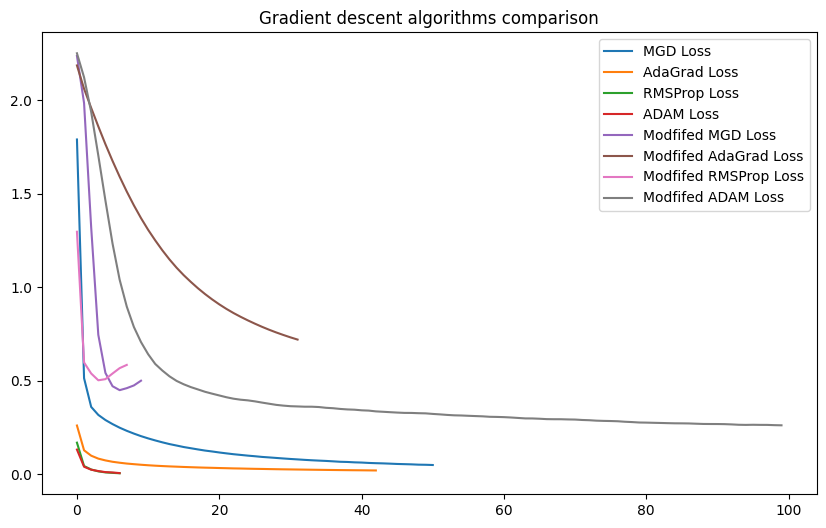

In [99]:
fig = plt.figure(figsize=(10, 6))

plt.plot(mgd_history, label='MGD Loss')
plt.plot(adagrad_history, label='AdaGrad Loss')
plt.plot(rmsprop_history, label='RMSProp Loss')
plt.plot(adam_history, label='ADAM Loss')
plt.plot(find_hist, label='Modfifed MGD Loss')
plt.plot(adagrad_find_history, label='Modfifed AdaGrad Loss')
plt.plot(rmsprop_find_history, label='Modfifed RMSProp Loss')
plt.plot(adam_find_history, label='Modfifed ADAM Loss')
plt.title('Gradient descent algorithms comparison')
plt.legend()
plt.show()

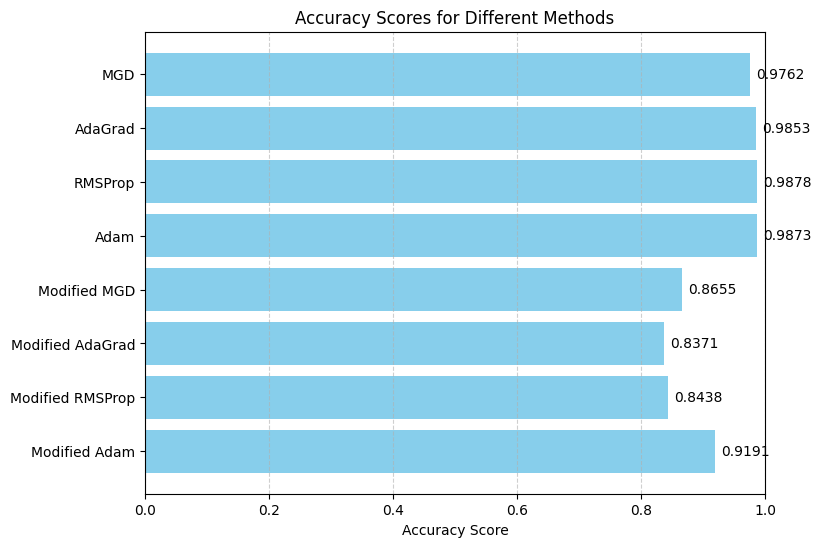

In [100]:
# List of accuracy scores
accuracy_scores = [mgd_acc, adagrad_acc, rmsprop_acc, adam_acc, find_acc, adagrad_find_acc, rmsprop_find_acc, adam_find_acc]
accuracy_scores = [r.item() / 100 for r in accuracy_scores]

# Corresponding labels or methods
methods = ['MGD', 'AdaGrad', 'RMSProp', 'Adam', 'Modified MGD', 'Modified AdaGrad', 'Modified RMSProp', 'Modified Adam']

# Create a bar chart
plt.figure(figsize=(8, 6))
plt.barh(methods, accuracy_scores, color='skyblue')
plt.xlabel('Accuracy Score')
plt.title('Accuracy Scores for Different Methods')
plt.xlim(0, 1)  # Set the x-axis limits from 0 to 1 for accuracy scores
plt.gca().invert_yaxis()  # Invert the y-axis to display the highest accuracy at the top
plt.grid(axis='x', linestyle='--', alpha=0.6)

# Display the values on the bars
for i, score in enumerate(accuracy_scores):
    plt.text(score + 0.01, i, f'{score:.4f}', va='center')

plt.show()